In [6]:
%load_ext autoreload
%autoreload 2

In [1]:
from plantclef.spark import get_spark
from pathlib import Path

spark = get_spark(cores=4, app_name="masking-notebook")
display(spark)

root = Path("~/shared/plantclef/data").expanduser().as_posix()
display(root)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/02 20:05:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/02 20:05:19 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


'/storage/home/hcoda1/8/amiyaguchi3/shared/plantclef/data'

In [2]:
from pyspark.sql import functions as F

stats = spark.read.parquet(f"{root}/morph/stats/test_2024_v2").cache()
stats.printSchema()
stats.count()

root
 |-- image_name: string (nullable = true)
 |-- sample_id: integer (nullable = true)
 |-- leaf_mask_stats: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- iteration: integer (nullable = true)
 |    |    |-- opening_mean: float (nullable = true)
 |    |    |-- opening_num_components: integer (nullable = true)
 |    |    |-- closing_mean: float (nullable = true)
 |    |    |-- closing_num_components: integer (nullable = true)
 |    |    |-- opening_closing_mean: float (nullable = true)
 |    |    |-- opening_closing_num_components: integer (nullable = true)
 |-- flower_mask_stats: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- iteration: integer (nullable = true)
 |    |    |-- opening_mean: float (nullable = true)
 |    |    |-- opening_num_components: integer (nullable = true)
 |    |    |-- closing_mean: float (nullable = true)
 |    |    |-- closing_num_components: integer (nullable = true)
 |    |    

1695

In [3]:
plant_stats = stats.select("image_name", F.explode("plant_mask_stats")).select(
    "image_name", "col.*"
)
plant_stats.printSchema()
plant_stats.count()

root
 |-- image_name: string (nullable = true)
 |-- iteration: integer (nullable = true)
 |-- opening_mean: float (nullable = true)
 |-- opening_num_components: integer (nullable = true)
 |-- closing_mean: float (nullable = true)
 |-- closing_num_components: integer (nullable = true)
 |-- opening_closing_mean: float (nullable = true)
 |-- opening_closing_num_components: integer (nullable = true)



16950

In [10]:
# compute quantiles for each of the metrics so we can add whisker plots for things
from itertools import chain


def whisker_metrics(col):
    return [
        F.min(col).alias(f"{col}_min"),
        F.max(col).alias(f"{col}_max"),
        F.mean(col).alias(f"{col}_mean"),
        F.stddev(col).alias(f"{col}_stddev"),
        F.approx_percentile(col, 0.05).alias(f"{col}_p5"),
        F.approx_percentile(col, 0.25).alias(f"{col}_p25"),
        F.approx_percentile(col, 0.5).alias(f"{col}_p50"),
        F.approx_percentile(col, 0.75).alias(f"{col}_p75"),
        F.approx_percentile(col, 0.95).alias(f"{col}_p95"),
    ]


agg_expression = list(
    chain.from_iterable(whisker_metrics(col) for col in plant_stats.columns[2:])
)
# display(agg_expression)

summary = plant_stats.groupBy("iteration").agg(*agg_expression).cache()
summary.printSchema()
summary.show(n=1, vertical=True)

root
 |-- iteration: integer (nullable = true)
 |-- opening_mean_min: float (nullable = true)
 |-- opening_mean_max: float (nullable = true)
 |-- opening_mean_mean: double (nullable = true)
 |-- opening_mean_stddev: double (nullable = true)
 |-- opening_mean_p5: float (nullable = true)
 |-- opening_mean_p25: float (nullable = true)
 |-- opening_mean_p50: float (nullable = true)
 |-- opening_mean_p75: float (nullable = true)
 |-- opening_mean_p95: float (nullable = true)
 |-- opening_num_components_min: integer (nullable = true)
 |-- opening_num_components_max: integer (nullable = true)
 |-- opening_num_components_mean: double (nullable = true)
 |-- opening_num_components_stddev: double (nullable = true)
 |-- opening_num_components_p5: integer (nullable = true)
 |-- opening_num_components_p25: integer (nullable = true)
 |-- opening_num_components_p50: integer (nullable = true)
 |-- opening_num_components_p75: integer (nullable = true)
 |-- opening_num_components_p95: integer (nullable =

-RECORD 0----------------------------------------------------
 iteration                             | 20                  
 opening_mean_min                      | 0.0                 
 opening_mean_max                      | 1.0                 
 opening_mean_mean                     | 0.8319330657634522  
 opening_mean_stddev                   | 0.15791429806987456 
 opening_mean_p5                       | 0.5768937           
 opening_mean_p25                      | 0.79572284          
 opening_mean_p50                      | 0.8737372           
 opening_mean_p75                      | 0.92493355          
 opening_mean_p95                      | 0.9748095           
 opening_num_components_min            | 0                   
 opening_num_components_max            | 263                 
 opening_num_components_mean           | 17.30265486725664   
 opening_num_components_stddev         | 22.51419253357011   
 opening_num_components_p5             | 1                   
 opening

-RECORD 0-----------------------
 iteration | 10                 
 min       | 0                  
 max       | 110                
 mean      | 9.35457227138643   
 stddev    | 11.034289746757848 
 p5        | 1                  
 p25       | 3                  
 p50       | 6                  
 p75       | 11                 
 p95       | 30                 
only showing top 1 row



,iteration,min,max,mean,stddev,p5,p25,p50,p75,p95
0,10,0,110,9.354572,11.034290,1,3,6,11,30
1,20,0,45,3.680236,3.601020,1,1,3,5,10
2,30,0,21,2.630678,2.246972,1,1,2,3,7
3,40,0,17,2.095575,1.638260,1,1,2,3,5
4,50,0,13,1.660767,1.235528,1,1,1,2,4
5,60,0,10,1.441298,1.009959,1,1,1,1,4
6,70,0,10,1.355752,0.863288,1,1,1,1,3
7,80,0,9,1.299115,0.750186,1,1,1,1,3
8,90,0,9,1.263717,0.706321,1,1,1,1,3
9,100,0,8,1.237168,0.660336,1,1,1,1,3


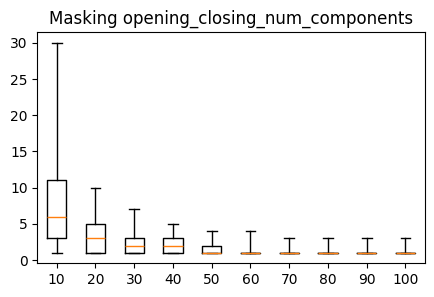

In [11]:
import matplotlib.pyplot as plt

metric = "opening_closing_num_components"
df = summary.select(
    "iteration",
    *[
        F.column(c).alias(c.replace(f"{metric}_", ""))
        for c in summary.columns
        if metric in c
    ],
).orderBy("iteration")
df.show(n=1, vertical=True)
pdf = df.toPandas()
display(pdf)

stats = [
    dict(
        med=r.p50,
        q1=r.p25,
        q3=r.p75,
        whislo=r.p5,
        whishi=r.p95,
        fliers=[],
        label=f"{r.iteration}",
    )
    for r in pdf.itertuples()
]

fig, ax = plt.subplots(figsize=(5, 3))
ax.bxp(stats)
plt.title(f"Masking {metric}")
plt.show()

-RECORD 0-----------------------
 iteration | 10                 
 min       | 0                  
 max       | 110                
 mean      | 9.35457227138643   
 stddev    | 11.034289746757848 
 p5        | 1                  
 p25       | 3                  
 p50       | 6                  
 p75       | 11                 
 p95       | 30                 
only showing top 1 row



,iteration,min,max,mean,stddev,p5,p25,p50,p75,p95
0,10,0,110,9.354572,11.034290,1,3,6,11,30
1,20,0,45,3.680236,3.601020,1,1,3,5,10
2,30,0,21,2.630678,2.246972,1,1,2,3,7
3,40,0,17,2.095575,1.638260,1,1,2,3,5
4,50,0,13,1.660767,1.235528,1,1,1,2,4
5,60,0,10,1.441298,1.009959,1,1,1,1,4
6,70,0,10,1.355752,0.863288,1,1,1,1,3
7,80,0,9,1.299115,0.750186,1,1,1,1,3
8,90,0,9,1.263717,0.706321,1,1,1,1,3
9,100,0,8,1.237168,0.660336,1,1,1,1,3


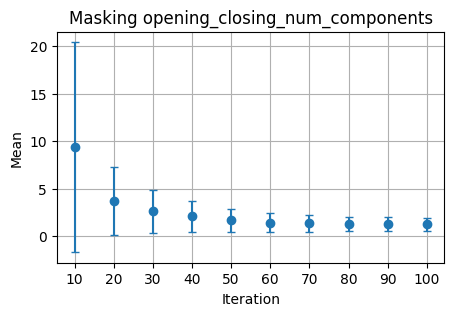

In [13]:
metric = "opening_closing_num_components"
df = summary.select(
    "iteration",
    *[
        F.column(c).alias(c.replace(f"{metric}_", ""))
        for c in summary.columns
        if metric in c
    ],
).orderBy("iteration")
df.show(n=1, vertical=True)
pdf = df.toPandas()
display(pdf)

# line plot with error bars
fig, ax = plt.subplots(figsize=(5, 3))
ax.errorbar(
    pdf.iteration,
    pdf["mean"],
    yerr=pdf["stddev"],
    fmt="o",
    capsize=3,
)
plt.title(f"Masking {metric}")
plt.xlabel("Iteration")
plt.ylabel("Mean")
plt.xticks(pdf.iteration)
plt.grid()

opening_mean


,iteration,min,max,mean,stddev,p5,p25,p50,p75,p95
0,10,0.0,0.999177,0.824492,0.157234,0.570212,0.788439,0.865251,0.918372,0.965298
1,20,0.0,1.000000,0.831933,0.157914,0.576894,0.795723,0.873737,0.924934,0.974810
2,30,0.0,1.000000,0.839255,0.158429,0.587871,0.801584,0.882008,0.932197,0.980698
3,40,0.0,1.000000,0.847552,0.159049,0.595159,0.808406,0.890023,0.942241,0.986985
4,50,0.0,1.000000,0.855747,0.159668,0.604009,0.817261,0.899507,0.953121,0.991381
5,60,0.0,1.000000,0.862613,0.159959,0.609901,0.823511,0.907233,0.960759,0.994197
6,70,0.0,1.000000,0.868357,0.160090,0.614116,0.830147,0.913894,0.966429,0.997023
7,80,0.0,1.000000,0.873293,0.160051,0.621248,0.837844,0.918907,0.971397,0.998450
8,90,0.0,1.000000,0.878007,0.159940,0.626214,0.845158,0.924277,0.975488,1.000000
9,100,0.0,1.000000,0.882303,0.159786,0.632198,0.850736,0.928465,0.979758,1.000000


opening_num_components


,iteration,min,max,mean,stddev,p5,p25,p50,p75,p95
0,10,0,522,37.014749,45.341279,2,8,22,48,126
1,20,0,263,17.302655,22.514193,1,4,10,21,61
2,30,0,115,9.918584,12.265721,1,2,5,13,34
3,40,0,82,6.490265,7.940733,1,2,4,8,22
4,50,0,66,4.709145,5.954452,1,1,2,6,16
5,60,0,52,3.706195,4.825753,1,1,2,4,13
6,70,0,45,3.128614,4.104017,1,1,1,4,11
7,80,0,39,2.710324,3.476075,1,1,1,3,9
8,90,0,35,2.354572,2.924866,1,1,1,2,8
9,100,0,30,2.115634,2.545841,1,1,1,2,7


closing_mean


,iteration,min,max,mean,stddev,p5,p25,p50,p75,p95,opening_min,opening_max,opening_mean,opening_stddev,opening_p5,opening_p25,opening_p50,opening_p75,opening_p95
0,10,0.0,0.990984,0.813629,0.156196,0.558793,0.775883,0.855164,0.908523,0.949140,0.0,0.999177,0.823202,0.157447,0.569202,0.787152,0.863820,0.917578,0.964603
1,20,0.0,0.989608,0.807938,0.156465,0.549750,0.769188,0.849782,0.902704,0.945844,0.0,1.000000,0.830330,0.158393,0.572889,0.794398,0.871534,0.923842,0.974094
2,30,0.0,0.987721,0.801616,0.156671,0.537590,0.762384,0.841911,0.897596,0.941016,0.0,1.000000,0.837315,0.159125,0.578811,0.798959,0.880251,0.930822,0.980437
3,40,0.0,0.983714,0.795039,0.157052,0.533848,0.752536,0.836048,0.890483,0.936329,0.0,1.000000,0.845385,0.159956,0.590175,0.805559,0.887847,0.941396,0.986985
4,50,0.0,0.979671,0.789993,0.157634,0.525889,0.745875,0.831306,0.886480,0.934162,0.0,1.000000,0.853406,0.160823,0.596539,0.814151,0.897436,0.952005,0.991297
5,60,0.0,0.973499,0.785545,0.158229,0.516669,0.740354,0.826616,0.882673,0.932143,0.0,1.000000,0.860252,0.161315,0.604173,0.819126,0.905385,0.960187,0.994197
6,70,0.0,0.966278,0.781213,0.158903,0.504774,0.735321,0.822769,0.880121,0.930042,0.0,1.000000,0.865872,0.161691,0.607322,0.825809,0.911611,0.965912,0.997004
7,80,0.0,0.961827,0.776875,0.159626,0.500311,0.727454,0.818850,0.876388,0.928307,0.0,1.000000,0.870718,0.161800,0.610466,0.833298,0.917125,0.970690,0.998450
8,90,0.0,0.958198,0.772642,0.160326,0.490324,0.720887,0.814381,0.872797,0.926388,0.0,1.000000,0.875347,0.161835,0.616699,0.840136,0.921760,0.974911,1.000000
9,100,0.0,0.956028,0.768272,0.161153,0.482360,0.714960,0.810185,0.869573,0.924060,0.0,1.000000,0.879602,0.161815,0.619768,0.845030,0.926130,0.979228,1.000000


closing_num_components


,iteration,min,max,mean,stddev,p5,p25,p50,p75,p95,opening_min,opening_max,opening_mean,opening_stddev,opening_p5,opening_p25,opening_p50,opening_p75,opening_p95
0,10,0,213,19.640708,21.123997,2,5,12,28,61,0,110,9.354572,11.034290,1,3,6,11,30
1,20,0,89,9.095575,8.380084,1,3,6,12,25,0,45,3.680236,3.601020,1,1,3,5,10
2,30,0,48,6.211799,5.017500,1,3,5,8,16,0,21,2.630678,2.246972,1,1,2,3,7
3,40,0,37,4.841298,3.612773,1,2,4,6,12,0,17,2.095575,1.638260,1,1,2,3,5
4,50,0,18,3.955162,2.690290,1,2,3,5,9,0,13,1.660767,1.235528,1,1,1,2,4
5,60,0,17,3.406490,2.198117,1,2,3,4,8,0,10,1.441298,1.009959,1,1,1,1,4
6,70,0,15,3.010029,1.951724,1,2,3,4,7,0,10,1.355752,0.863288,1,1,1,1,3
7,80,0,12,2.717404,1.733352,1,1,2,3,6,0,9,1.299115,0.750186,1,1,1,1,3
8,90,0,13,2.524484,1.595954,1,1,2,3,6,0,9,1.263717,0.706321,1,1,1,1,3
9,100,0,13,2.360472,1.511614,1,1,2,3,5,0,8,1.237168,0.660336,1,1,1,1,3


opening_closing_mean


,iteration,min,max,mean,stddev,p5,p25,p50,p75,p95
0,10,0.0,0.999177,0.823202,0.157447,0.569202,0.787152,0.863820,0.917578,0.964603
1,20,0.0,1.000000,0.830330,0.158393,0.572889,0.794398,0.871534,0.923842,0.974094
2,30,0.0,1.000000,0.837315,0.159125,0.578811,0.798959,0.880251,0.930822,0.980437
3,40,0.0,1.000000,0.845385,0.159956,0.590175,0.805559,0.887847,0.941396,0.986985
4,50,0.0,1.000000,0.853406,0.160823,0.596539,0.814151,0.897436,0.952005,0.991297
5,60,0.0,1.000000,0.860252,0.161315,0.604173,0.819126,0.905385,0.960187,0.994197
6,70,0.0,1.000000,0.865872,0.161691,0.607322,0.825809,0.911611,0.965912,0.997004
7,80,0.0,1.000000,0.870718,0.161800,0.610466,0.833298,0.917125,0.970690,0.998450
8,90,0.0,1.000000,0.875347,0.161835,0.616699,0.840136,0.921760,0.974911,1.000000
9,100,0.0,1.000000,0.879602,0.161815,0.619768,0.845030,0.926130,0.979228,1.000000


opening_closing_num_components


,iteration,min,max,mean,stddev,p5,p25,p50,p75,p95
0,10,0,110,9.354572,11.034290,1,3,6,11,30
1,20,0,45,3.680236,3.601020,1,1,3,5,10
2,30,0,21,2.630678,2.246972,1,1,2,3,7
3,40,0,17,2.095575,1.638260,1,1,2,3,5
4,50,0,13,1.660767,1.235528,1,1,1,2,4
5,60,0,10,1.441298,1.009959,1,1,1,1,4
6,70,0,10,1.355752,0.863288,1,1,1,1,3
7,80,0,9,1.299115,0.750186,1,1,1,1,3
8,90,0,9,1.263717,0.706321,1,1,1,1,3
9,100,0,8,1.237168,0.660336,1,1,1,1,3


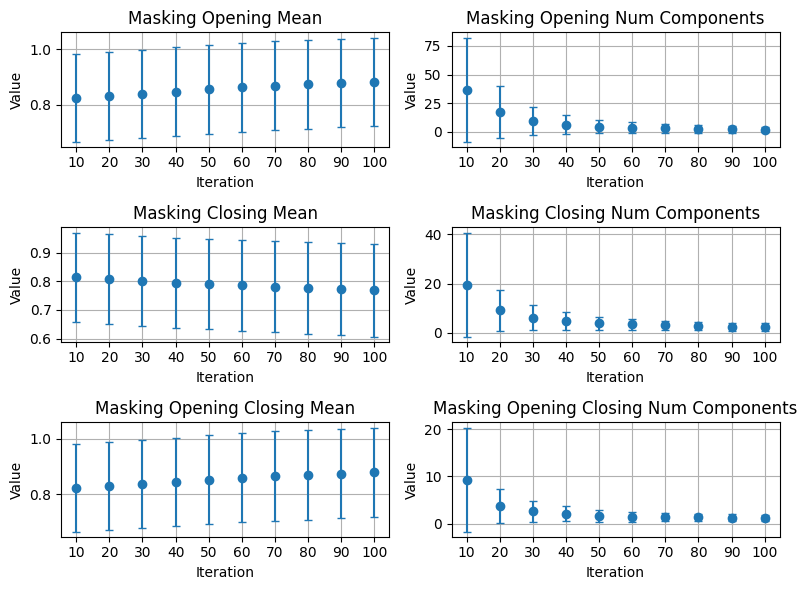

In [20]:
# go over all into one big subplot
# left is the "opening", "closing", "opening_closing"
# right is the "mean" and "num_components"
fig, axes = plt.subplots(3, 2, figsize=(8, 6))
for ax, metric in zip(axes.flatten(), plant_stats.columns[2:]):
    df = summary.select(
        "iteration",
        *[
            F.column(c).alias(c.replace(f"{metric}_", ""))
            for c in summary.columns
            if metric in c
        ],
    ).orderBy("iteration")
    pdf = df.toPandas()
    print(metric)
    display(pdf)

    # line plot with error bars
    ax.errorbar(
        pdf.iteration,
        pdf["mean"],
        yerr=pdf["stddev"],
        fmt="o",
        capsize=3,
    )
    ax.set_title(f"Masking {metric.replace('_', ' ').title()}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Value")
    ax.set_xticks(pdf.iteration)
    ax.grid()
fig.tight_layout()
plt.show()

# workflow

In [24]:
from plantclef.spark import get_spark
from pathlib import Path
from pyspark.sql import functions as F
from itertools import chain

spark = get_spark(cores=4, app_name="masking-notebook")
root = Path("~/shared/plantclef/data").expanduser().as_posix()
stats = spark.read.parquet(f"{root}/morph/stats/test_2024_v2").cache()

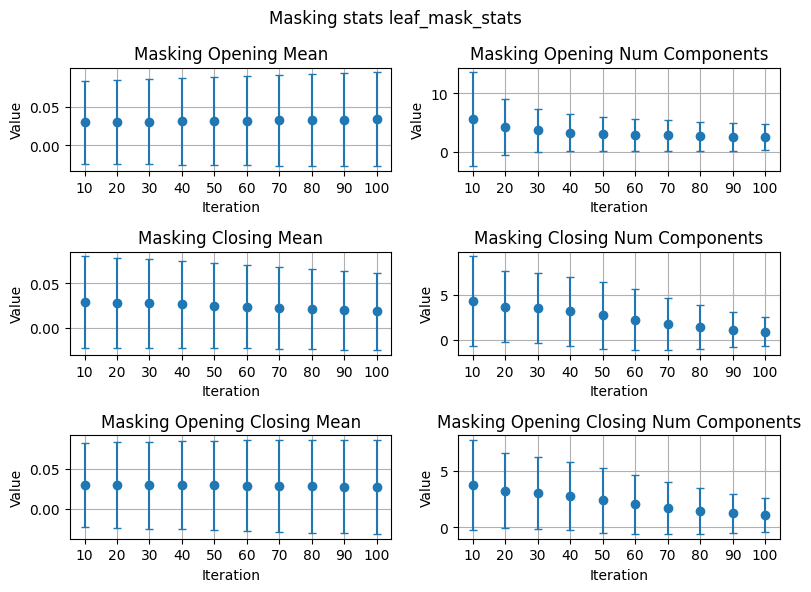

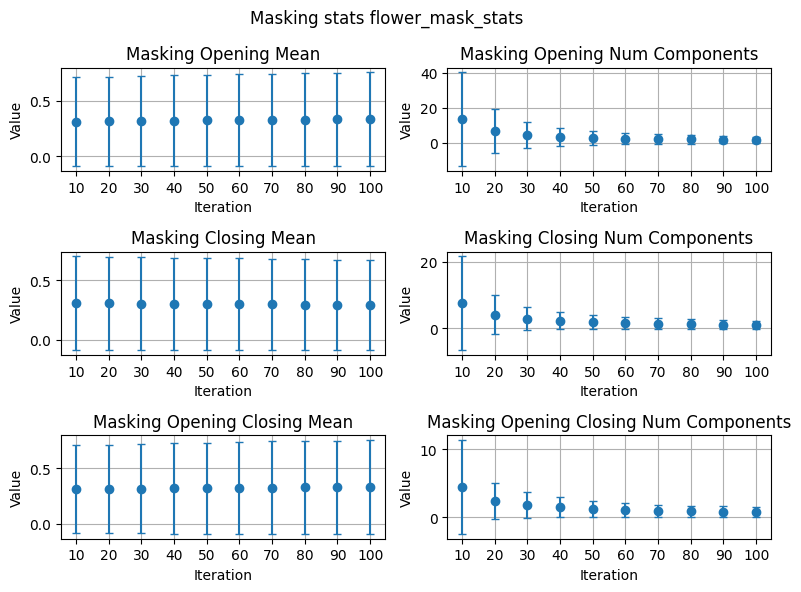

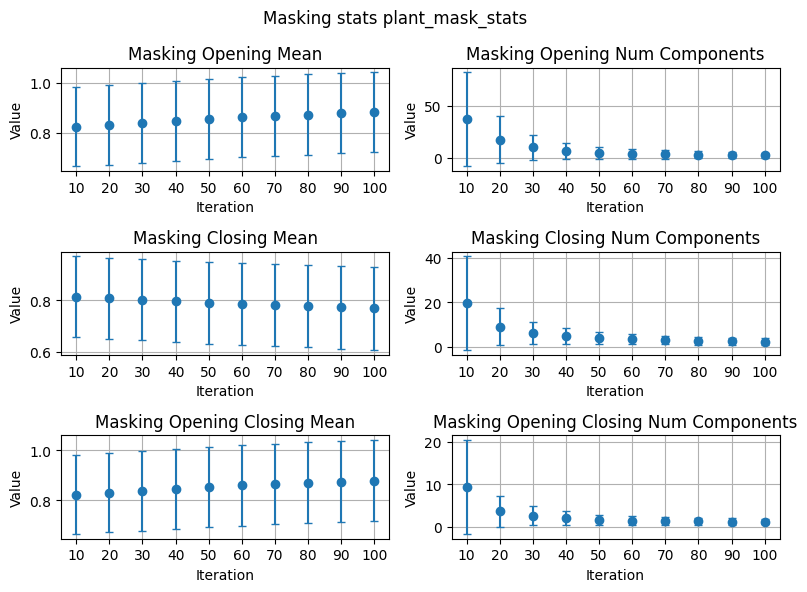

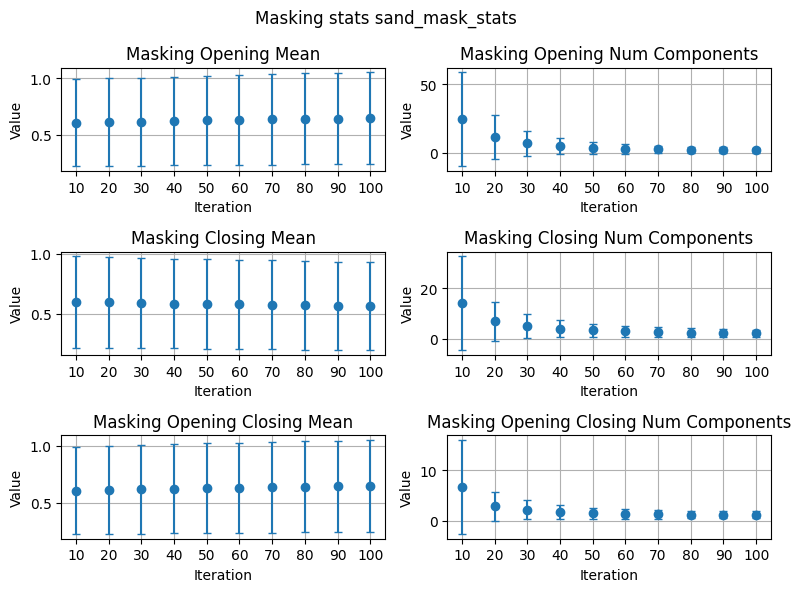

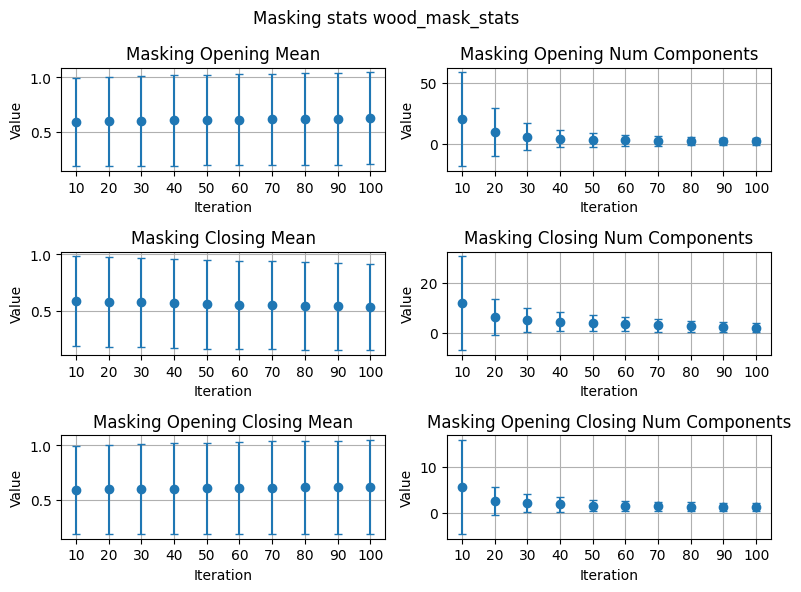

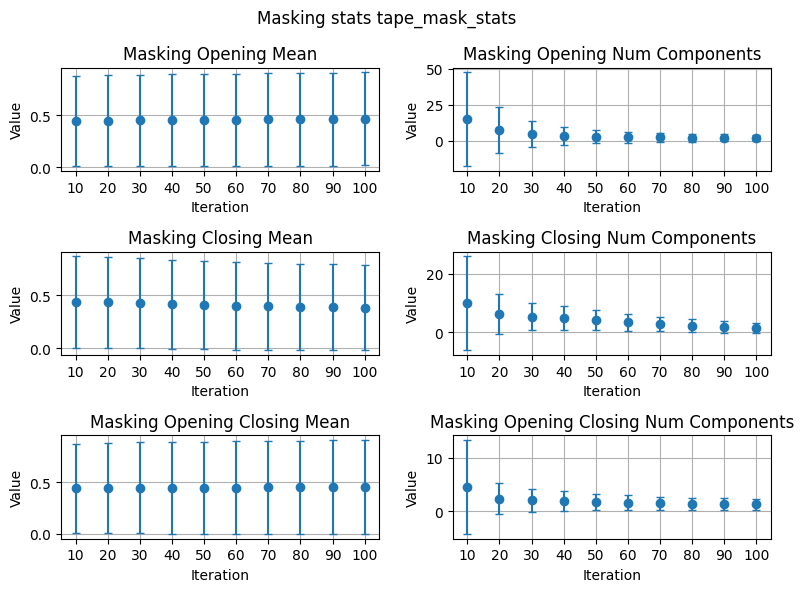

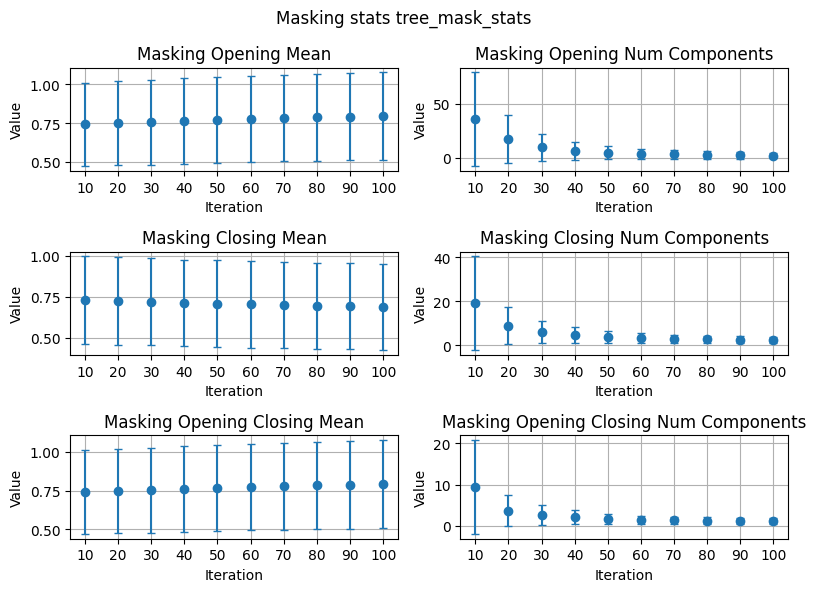

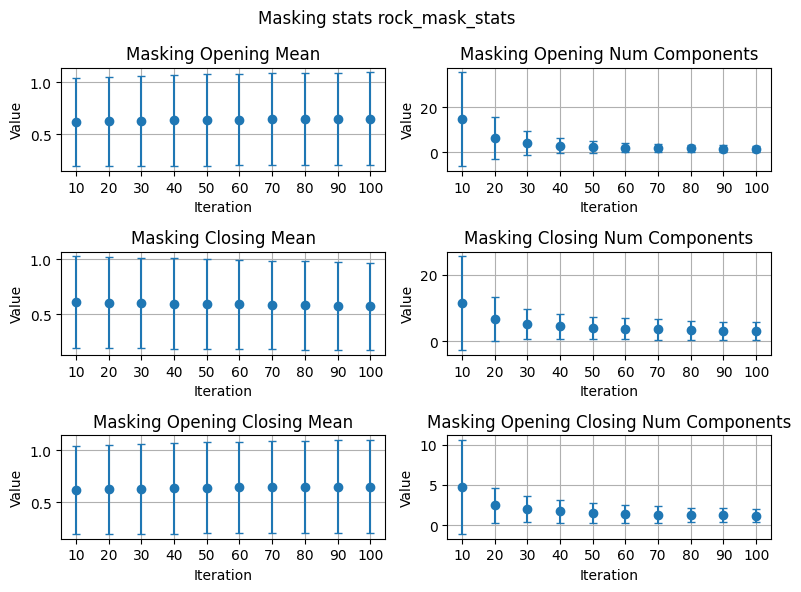

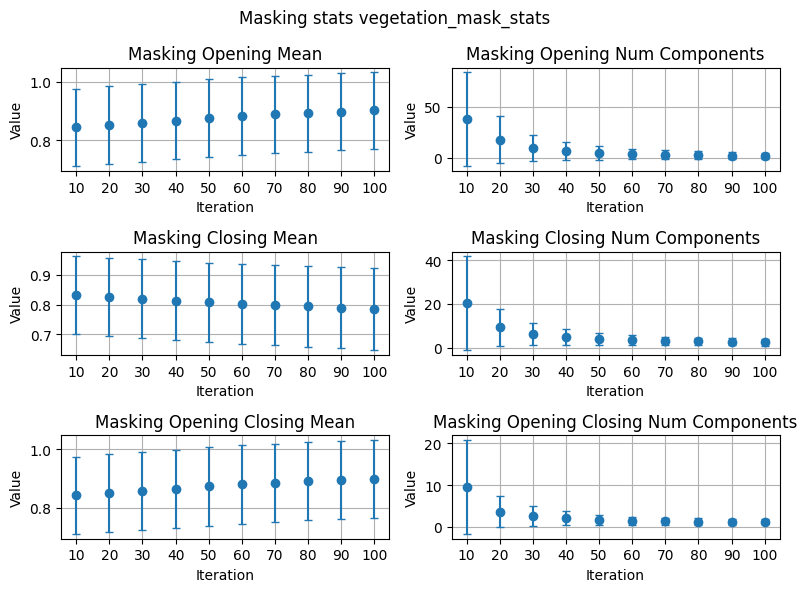

In [23]:
def whisker_metrics(col):
    return [
        F.min(col).alias(f"{col}_min"),
        F.max(col).alias(f"{col}_max"),
        F.mean(col).alias(f"{col}_mean"),
        F.stddev(col).alias(f"{col}_stddev"),
        F.approx_percentile(col, 0.05).alias(f"{col}_p5"),
        F.approx_percentile(col, 0.25).alias(f"{col}_p25"),
        F.approx_percentile(col, 0.5).alias(f"{col}_p50"),
        F.approx_percentile(col, 0.75).alias(f"{col}_p75"),
        F.approx_percentile(col, 0.95).alias(f"{col}_p95"),
    ]


def compute_stats(stats, mask_name):
    plant_stats = stats.select("image_name", F.explode(mask_name)).select(
        "image_name", "col.*"
    )

    summary = (
        plant_stats.groupBy("iteration")
        .agg(
            *list(
                chain.from_iterable(
                    whisker_metrics(col) for col in plant_stats.columns[2:]
                )
            )
        )
        .cache()
    )

    fig, axes = plt.subplots(3, 2, figsize=(8, 6))
    fig.suptitle(f"Masking stats {mask_name}")
    for ax, metric in zip(axes.flatten(), plant_stats.columns[2:]):
        df = summary.select(
            "iteration",
            *[
                F.column(c).alias(c.replace(f"{metric}_", ""))
                for c in summary.columns
                if metric in c
            ],
        ).orderBy("iteration")
        pdf = df.toPandas()
        # print(metric)
        # display(pdf)

        # line plot with error bars
        ax.errorbar(
            pdf.iteration,
            pdf["mean"],
            yerr=pdf["stddev"],
            fmt="o",
            capsize=3,
        )
        ax.set_title(f"Masking {metric.replace('_', ' ').title()}")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Value")
        ax.set_xticks(pdf.iteration)
        ax.grid()
    fig.tight_layout()
    return fig


for col in stats.columns:
    if "mask" not in col:
        continue
    compute_stats(stats, col)
    plt.show()